# Tutorial: Reachable Set Computation (Graph-based Propagation)

This tutorial demonstrates how to use CommonRoad-Reach to compute the reachable sets of a considered ego vehicle given a CommonRoad scenario, using the graph-based propagation method.

Please make sure that you have correctly installed the package and have gone through the tutorials for **CommonRoad Input-Output** beforehand.

## Building Configuration

Computing the reachable sets requires a configuration that hold essential parameters of the ego vehicle. The configuration is often built from default parameters (located in `./configurations/defaults/`) and scenario-specific parameters. If you wish you overwrite a parameter for a specific scenario, simply create a `.yaml` file with the name of the scenario under `./configurations/` and store the parameter in it. In the following, we explain some of the important parameters in the configuration file.

* `planning.steps_computation`: Number of time steps for which the reachable set should be computed.
* `planning.coordinate_system`: Coordinate system in which the reachable set should be computed. Computations within the global Cartesian ("CART") and local curvilinear ("CVLN") coordinate systems are supported.
* `planning.reference_point`: Reference point of computation on the vehicle. This can either be set on the center ("CENTER") or on the rear axle ("REAR") of the vehicle. This affects the results of collision checks with surrounding obstacles.
* `vehicle.ego`: Ego-vehicle-specific paramters. Values set to `!!null` will be loaded from vehicle parameters (see [Vehicle Models](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf), p24) based on the specified vehicle type id. Note that the parameters loaded from the vehicle models are vehicle-centric, and one often requires different velocity and acceleration profiles for computation within the Cartesian coordinate system.
* `reachable_set.mode_computation`: Parameter indicating the mode for reachable set computation. Computations with Python backend, C++ backend, and graph-based propagation (both offline and online) are supported.
* `reachable_set.mode_repartition`: Parameter indicating the mode for drivable area repartition.
* `reachable_set.mode_inflation`: Parameter indicating the mode inflating the shape of the ego vehicle.
* `reachable_set.size_grid`: Grid size for discretizing drivable area.
* `reachable_set.radius_terminal_split`: Threshold for terminating the split of drivable areas in collision checks.

We proceed with building the configuration for an example scenario.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import commonroad_reach.utility.logger as util_logger
from commonroad_reach.data_structure.configuration_builder import ConfigurationBuilder
from commonroad_reach.data_structure.reach.reach_interface import ReachableSetInterface
from commonroad_reach.utility import visualization as util_visual

# ==== specify scenario
name_scenario = "ARG_Carcarana-1_1_T-1"

# ==== build configuration
config = ConfigurationBuilder(path_root="..").build_configuration(name_scenario)
config.update()
logger = util_logger.initialize_logger(config)

Running cmake --build & --install in /home/lercher/tum/commonroad-reachable-set/build/Debug_cp310-cp310-manylinux_2_35_x86_64

# ===== CommonRoad-Reach Configuration Builder ===== #
# Root path: 
# 	..
# Using default configs from: 
# 	/home/lercher/tum/commonroad-reachable-set/commonroad_reach/configurations_default
# Using scenario config from: 
# 	 ../configurations/ARG_Carcarana-1_1_T-1.yaml


Lanelets_of_goal_position not given
Could not find a single goal position or lane
Starting NoGoalFound Planner, since no goal information was found


## Offline Stage

The graph-based propagation method for computing reachable sets consists of an offline stage and an online stage. In the offline stage, we precompute reachable sets without considering obstacles in the scenario. Note: computing the offline stage for tens of steps may take up to several hours.

In [2]:
config.planning.steps_computation = 12
config.reachable_set.mode_computation = 4
config.print_configuration_summary()


# ===== CommonRoad-Reach Configuration Summary ===== #
# ARG_Carcarana-1_1_T-1
# Planning:
# 	dt: 0.1
# 	steps: 12
# 	coordinate system: curvilinear
# Vehicle (Ego):
# 	vehicle type id: 2
# 	v: lon_min = 0.0, lon_max = 20.0, lat_min = -4.0, lat_max = 4.0, max = 30.0
# 	a: lon_min = -6.0, lon_max = 6.0, lat_min = -2.0, lat_max = 2.0, max = 6.0
# Reachable set:
# 	computation mode: graph-based (offline)
# 	repartition mode: collision check, repartition
# 	inflation mode: inscribed circle
# 	obstacle rasterization: False
# 	grid size: 0.25
# 	split radius: 0.7
# 	prune: True
# 	num threads: 4
# ================================= #


In [3]:
# ==== compute offline reachable sets using reachability interface
reach_interface = ReachableSetInterface(config)
reach_interface.compute_reachable_sets()

* Computing reachable sets...
result saved to pickle file: ../output/offline_data/offline_nt1_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle
result saved to pickle file: ../output/offline_data/offline_nt2_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle
result saved to pickle file: ../output/offline_data/offline_nt3_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle
result saved to pickle file: ../output/offline_data/offline_nt4_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle
result saved to pickle file: ../output/offline_data/offline_nt5_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle
result saved to pickle file: ../output/offline_data/offline_nt6_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle
result saved to pickle file: ../output/offline_data/offline_nt7_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_

## Online Stage

Now that we have executed the offline stage, we proceed with the online stage, which removes edges between parent reach nodes and child reach nodes due to collision with obstacles.

In [4]:
config.reachable_set.mode_computation = 3
config.reachable_set.name_pickle_offline = "offline_nt12_CVLN_alonmax6.0_alatmax2.0_vlonmax20.0_vlatmax4.0_ms6_dx0.25_ver2024.1.pickle"
config.update()
config.print_configuration_summary()

Lanelets_of_goal_position not given
Could not find a single goal position or lane
Starting NoGoalFound Planner, since no goal information was found



# ===== CommonRoad-Reach Configuration Summary ===== #
# ARG_Carcarana-1_1_T-1
# Planning:
# 	dt: 0.1
# 	steps: 12
# 	coordinate system: curvilinear
# Vehicle (Ego):
# 	vehicle type id: 2
# 	v: lon_min = 0.0, lon_max = 20.0, lat_min = -4.0, lat_max = 4.0, max = 30.0
# 	a: lon_min = -6.0, lon_max = 6.0, lat_min = -2.0, lat_max = 2.0, max = 6.0
# Reachable set:
# 	computation mode: graph-based (online)
# 	repartition mode: collision check, repartition
# 	inflation mode: inscribed circle
# 	obstacle rasterization: False
# 	grid size: 0.25
# 	split radius: 0.7
# 	prune: True
# 	num threads: 4
# ================================= #


In [5]:
# ==== reset config and recompute reachable sets
reach_interface.reset(config)
reach_interface.compute_reachable_sets()

* Loading offline computation result...


Lanelets_of_goal_position not given
Could not find a single goal position or lane
Starting NoGoalFound Planner, since no goal information was found


* Computing reachable sets...
	Took: 	0.002s
	Configuration file saved.


* Plotting reachable sets...
	Saving ../output/ARG_Carcarana-1_1_T-1/png_reach_00000.png
	Saving ../output/ARG_Carcarana-1_1_T-1/png_reach_00005.png
	Saving ../output/ARG_Carcarana-1_1_T-1/png_reach_00010.png
	Creating GIF...
	Reachable sets plotted.


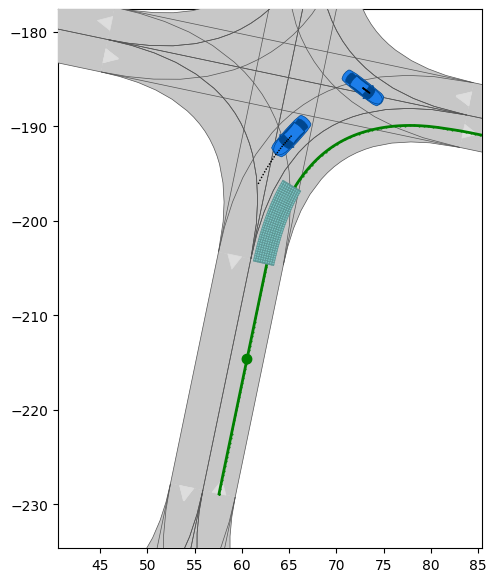

In [6]:
# ==== plot computation results and save as gifs
util_visual.plot_scenario_with_reachable_sets(reach_interface, figsize=(7, 7))

* Plotting reachable sets...


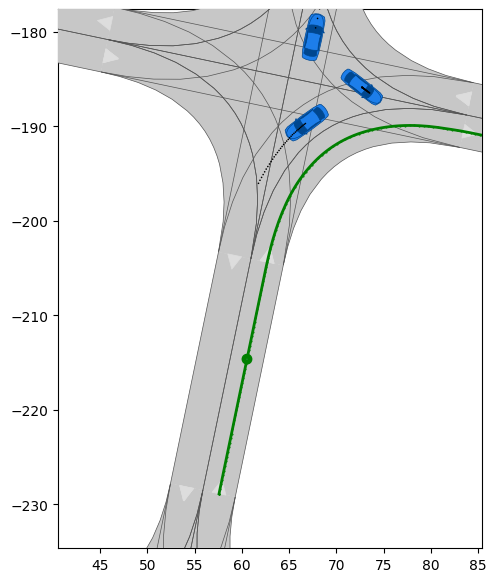

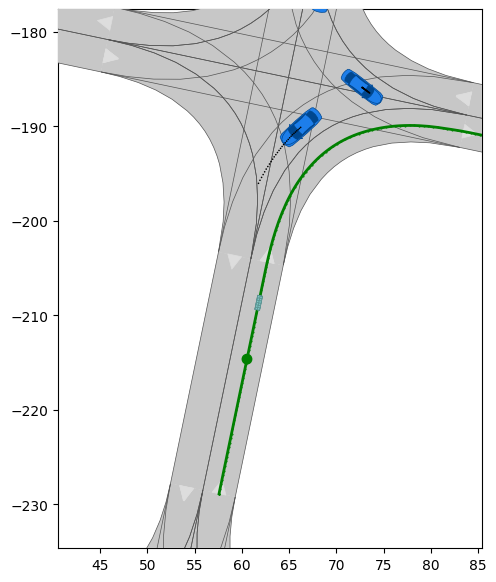

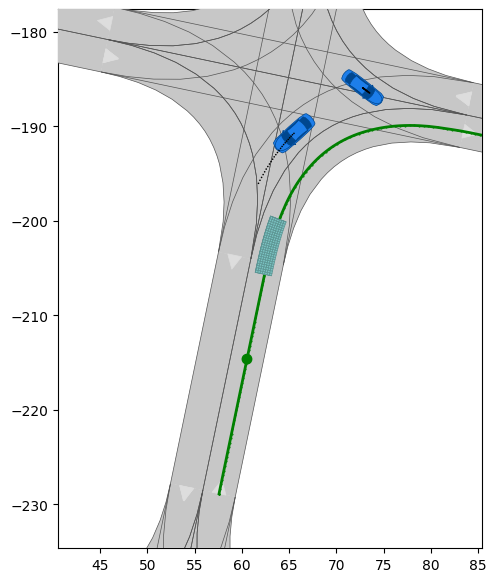

	Reachable sets plotted.


In [7]:
# ==== visualize reachable sets at specified steps
config.debug.save_plots = 0
util_visual.plot_scenario_with_reachable_sets(reach_interface, steps=[0, 5, 10, 15], figsize=(7, 7))